# Spotify Music Genres vs Unemployment Analysis 

### This notbook analyises the trends of Spotify listeners' genre preferences and if these have noticeable shifts in correlation with Unemployment. 

#### Contents:
- Import relevant libraries and download the dataset
- Analyse the dataset
- Brief eploratory data analysis of GDP against genre trends
- Regression analysis of Unemployment against genre trends
- Summary of findings, next steps and lessons learnt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import zscore

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
spotify_genre_df = pd.read_csv('../data/ons_genre_including_genregroup_new.csv')

In [4]:
spotify_genre_df.head()

,year_quarter,genre,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%)
0,2016 Q4,R&B,R&B,2414608.0,589476.0,1.5,369850.0,4.7
1,2016 Q4,Pop,Pop,2406621.0,589476.0,1.5,369850.0,4.7
2,2016 Q4,Pop,Pop,2345002.0,589476.0,1.5,369850.0,4.7
3,2016 Q4,Rock,Rock/Punk/Metal,1879767.0,589476.0,1.5,369850.0,4.7
4,2016 Q4,R&B,R&B,1797034.0,589476.0,1.5,369850.0,4.7


In [5]:
spotify_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year_quarter           9471 non-null   object 
 1   genre                  9471 non-null   object 
 2   Genre_Group            9471 non-null   object 
 3   streams                9471 non-null   float64
 4   gdp_(£m)               9471 non-null   float64
 5   inflation_(%)          9471 non-null   float64
 6   hfce_(£m)              9471 non-null   float64
 7   unemployment_rate_(%)  9471 non-null   float64
dtypes: float64(5), object(3)
memory usage: 592.1+ KB


#### Grouping the dataset by quarterly streams per genre

In [6]:
spotify_grouped_df = spotify_genre_df.groupby(['year_quarter', 'Genre_Group']).agg({
    'streams': 'sum',
    'gdp_(£m)': 'first',
    'inflation_(%)': 'first',
    'hfce_(£m)': 'first',
    'unemployment_rate_(%)': 'first'
}).reset_index()


In [7]:
spotify_grouped_df.head()

,year_quarter,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%)
0,2016 Q4,Christmas,19182659.0,589476.0,1.5,369850.0,4.7
1,2016 Q4,Dance/House,10253538.0,589476.0,1.5,369850.0,4.7
2,2016 Q4,Disco,1033984.0,589476.0,1.5,369850.0,4.7
3,2016 Q4,Electronic,7981704.0,589476.0,1.5,369850.0,4.7
4,2016 Q4,Folk,281777.0,589476.0,1.5,369850.0,4.7


In [8]:
spotify_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year_quarter           399 non-null    object 
 1   Genre_Group            399 non-null    object 
 2   streams                399 non-null    float64
 3   gdp_(£m)               399 non-null    float64
 4   inflation_(%)          399 non-null    float64
 5   hfce_(£m)              399 non-null    float64
 6   unemployment_rate_(%)  399 non-null    float64
dtypes: float64(5), object(2)
memory usage: 21.9+ KB


In [9]:
spotify_grouped_df['Genre_Group'].unique()  

array(['Christmas', 'Dance/House', 'Disco', 'Electronic', 'Folk', 'Funk',
       'Indie', 'Jazz', 'Musicals', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing', 'Chill', 'Latin',
       'Afrobeats', 'Country', 'K-Pop', 'Other', 'Acoustic'], dtype=object)

#### Obtaining top 5 most popular genres by quarter 

In [10]:
quarterly_top5_genres = spotify_grouped_df.groupby(['year_quarter', 'Genre_Group'])['streams'].sum().reset_index()

quarterly_top5_genres = quarterly_top5_genres.groupby('year_quarter').apply(
    lambda x: x.nlargest(5, 'streams')).reset_index(drop=True)

print("Top 5 Genres by Total Streams:")
quarterly_top5_genres.head()


Top 5 Genres by Total Streams:


,year_quarter,Genre_Group,streams
0,2016 Q4,Pop,38075668.0
1,2016 Q4,Christmas,19182659.0
2,2016 Q4,R&B,13161526.0
3,2016 Q4,Rock/Punk/Metal,11896867.0
4,2016 Q4,Dance/House,10253538.0


#### Now put top 5 into pivot table

In [11]:
top5_genres = (
    spotify_grouped_df.groupby('Genre_Group')['streams']
    .sum()
    .nlargest(5)
    .index
)

filtered_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'].isin(top5_genres)]

pivot5_df = filtered_df.pivot_table(
    index='year_quarter',
    columns='Genre_Group',
    values='streams',
    aggfunc='sum'
)

pivot5_df = pivot5_df.sort_index()

pivot5_df.head(5)

Genre_Group,Dance/House,Electronic,Pop,Rap/Hip-Hop,Rock/Punk/Metal
year_quarter,,,,,
2016 Q4,10253538.0,7981704.0,38075668.0,10039293.0,11896867.0
2017 Q1,215870086.0,238974966.0,776097326.0,247853741.0,67154983.0
2017 Q2,233950452.0,237021087.0,681555862.0,386868632.0,71408381.0
2017 Q3,170824366.0,253981726.0,611291097.0,288801271.0,71241735.0
2017 Q4,157743587.0,173483456.0,562691589.0,333065020.0,92200080.0


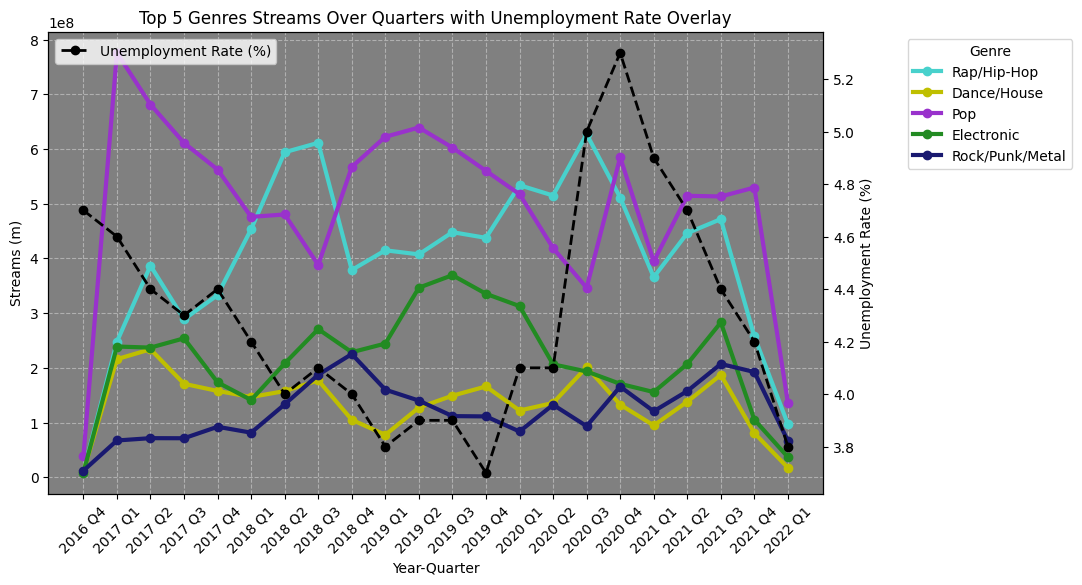

In [12]:
# this creates the figure and colours the background grey
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_facecolor('grey')

# axis 1 will plot the genre trends 
ax1.plot(pivot5_df.index, pivot5_df['Rap/Hip-Hop'], label='Rap/Hip-Hop', color='mediumturquoise', linewidth=3, marker='o')  
ax1.plot(pivot5_df.index, pivot5_df['Dance/House'], label='Dance/House', color='y', linewidth=3, marker='o')  
ax1.plot(pivot5_df.index, pivot5_df['Pop'], label='Pop', color='darkorchid', linewidth=3, marker='o') 
ax1.plot(pivot5_df.index, pivot5_df['Electronic'], label='Electronic', color='forestgreen', linewidth=3, marker='o')  
ax1.plot(pivot5_df.index, pivot5_df['Rock/Punk/Metal'], label='Rock/Punk/Metal', color='midnightblue', linewidth=3, marker='o') 

# axis 1 labels/title/legend and styling 
ax1.set_xlabel('Year-Quarter')
ax1.set_ylabel('Streams (m)')
ax1.set_title('Top 5 Genres Streams Over Quarters with Unemployment Rate Overlay')
ax1.tick_params(axis='y')
ax1.legend(title='Genre', bbox_to_anchor=(1.10, 1), loc='upper left') 
ax1.grid(linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# axis 2 will plot the unemployment line 
ax2 = ax1.twinx()

unemployment_by_quarter = spotify_grouped_df.groupby('year_quarter')['unemployment_rate_(%)'].mean().loc[pivot5_df.index]

ax2.plot(unemployment_by_quarter.index, 
         unemployment_by_quarter.values, 
         color='black', 
         label='Unemployment Rate (%)', 
         linestyle='--', 
         linewidth=2, 
         marker='o'
        )

# axis 2 labels and legend
ax2.set_ylabel('Unemployment Rate (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(['Unemployment Rate (%)'], loc='upper left')

plt.show()

### Top 5 Genres Streams Over Quarters with Unemployment Overlay:

#### The above plot shows little correlation with Unemployment, however there is a slight increase in Rap/Hip-Hop, Pop and Electronic during high unemployment times in the middle of covid but this could be down to more people streaming popular genres while out of work. This spike in Rap/Hip-Hop, Pop and Electronic is also inline with the first lockdown when people could have been searching for alternative forms of free entertainment. 

#### To analyse specific genre trends with unemployment I'll carry out a correlation matrix 


In [13]:
spotify_grouped_df['Genre_Group'].unique()

array(['Christmas', 'Dance/House', 'Disco', 'Electronic', 'Folk', 'Funk',
       'Indie', 'Jazz', 'Musicals', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing', 'Chill', 'Latin',
       'Afrobeats', 'Country', 'K-Pop', 'Other', 'Acoustic'], dtype=object)

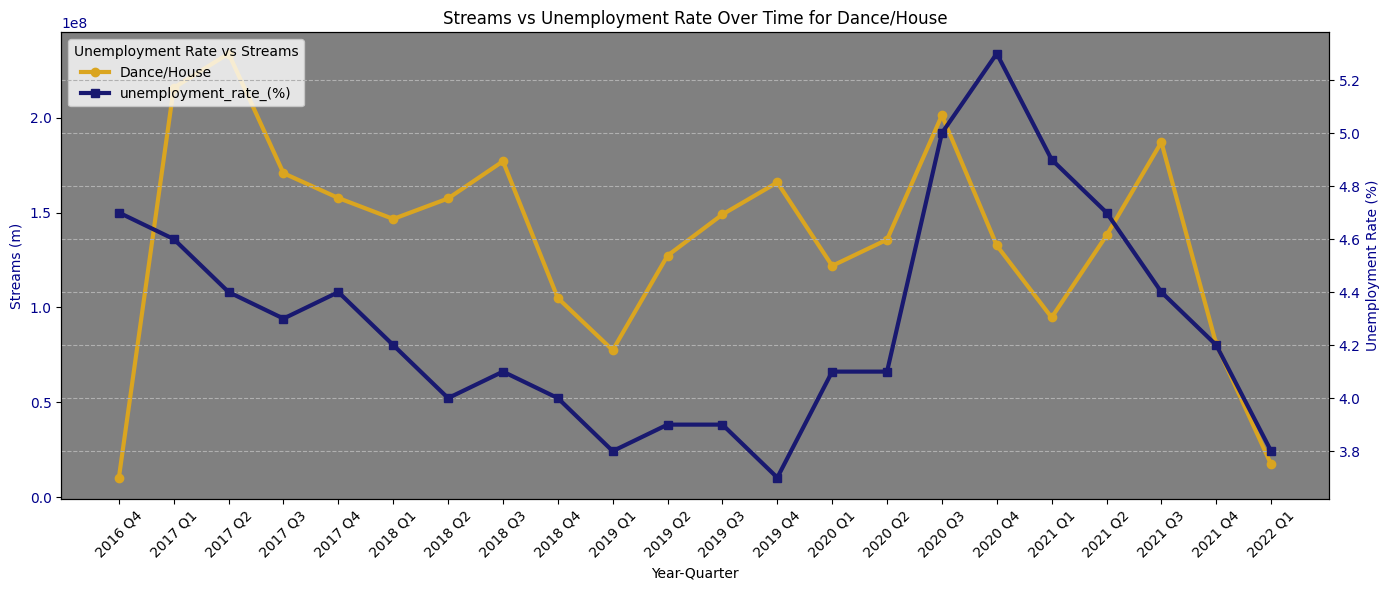

In [14]:
genre = 'Dance/House'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='goldenrod',  linewidth='3', marker='o', label='Dance/House')
ax1.set_ylabel('Streams (m)', color='darkblue')
ax1.set_xlabel('Year-Quarter')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['unemployment_rate_(%)'], color='midnightblue', linewidth='3', marker='s', label='unemployment_rate_(%)')
ax2.set_ylabel('Unemployment Rate (%)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title(f'Streams vs Unemployment Rate Over Time for {genre}')
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='Unemployment Rate vs Streams')


plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

### Streams vs Unemployment Rate Over Time for Dance/House:

#### There is a slight lag with negative corerlation in streams during the later quarters of covid when unemployment was high. As we've witnessed in the strong possitive correlation of chill streams and unemployment I though it would be interesting to look at other upbeat genre streaming trends during this time. The trend for Dance/House streams over time is undulating so there don't appear to be any outliers during the covid period. However the increase in Dance/House streams during the first lockdown could be down to people being stuck at home with hospitality and liesure closed they could be looking for free forms of entertainment from their own homes. What would be great do dive deeper into is looking at the number of Spotify users during this time and subscription changes. So are subscribers switching to free tiers etc. Is the volume of listeners on the site increasing and so on.

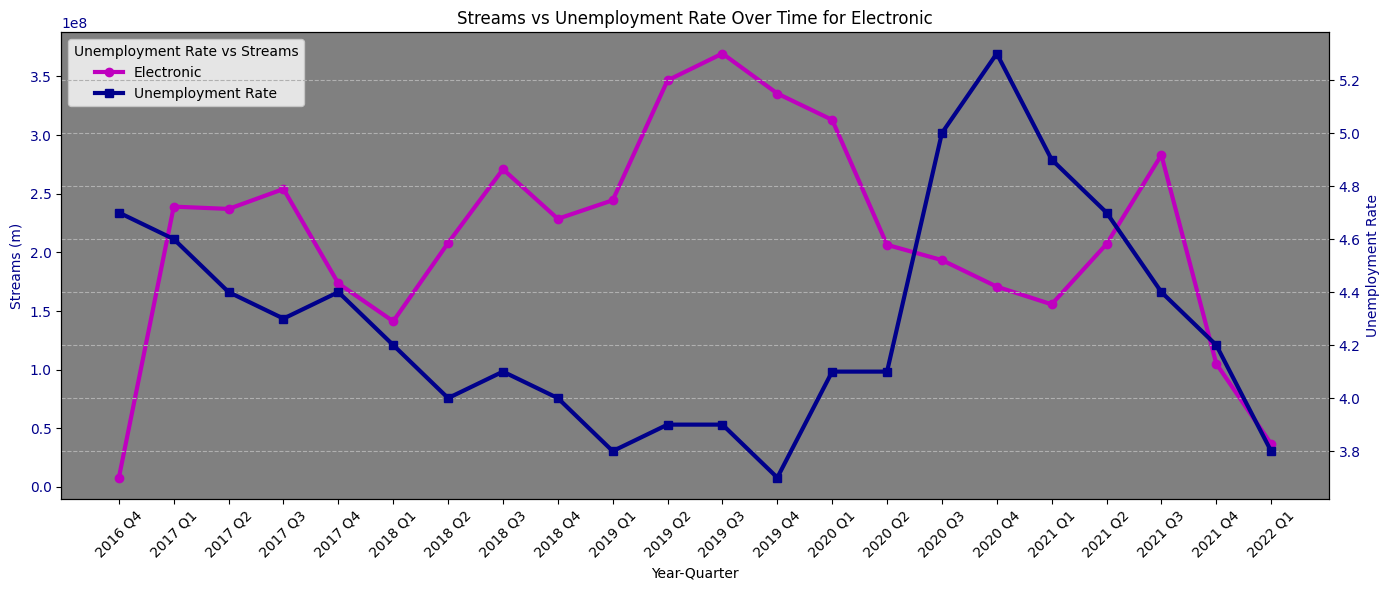

In [15]:
genre = 'Electronic'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='m', linewidth='3', marker='o', label='Electronic')
ax1.set_ylabel('Streams (m)', color='darkblue')
ax1.set_xlabel('Year-Quarter')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['unemployment_rate_(%)'], color='darkblue',  linewidth='3', marker='s', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title(f'Streams vs Unemployment Rate Over Time for {genre}')
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='Unemployment Rate vs Streams')


plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

#### Electronic and unemployment have a medium negative correlation. This could further support the insight that people are looking for more relaxing tempo of music during this stressful time. Sentiment analysis over this period would be great to dive deeper into. 

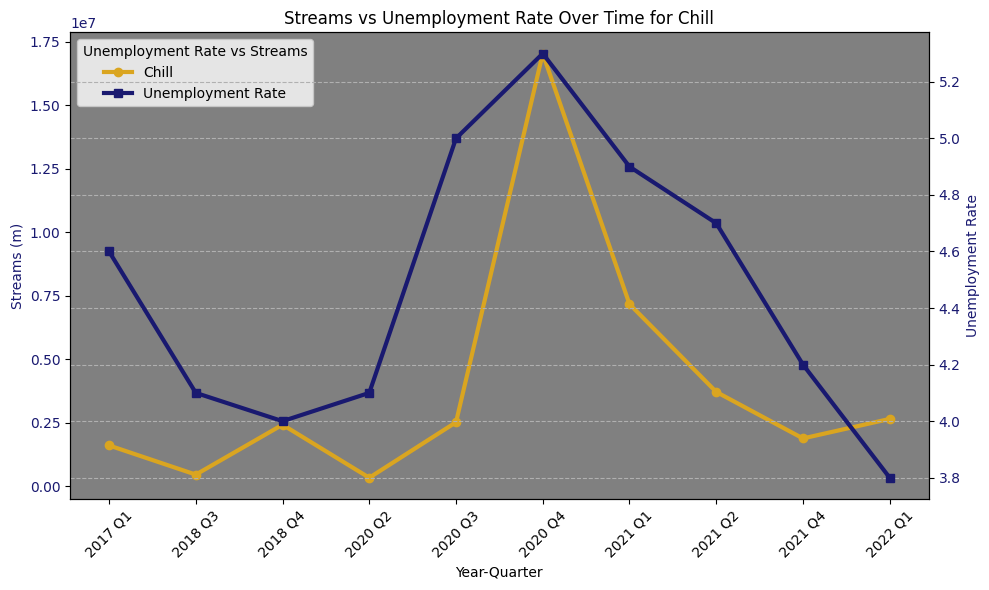

In [16]:
genre = 'Chill'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='goldenrod', linewidth='3', marker='o', label='Chill')
ax1.set_ylabel('Streams (m)', color='midnightblue')
ax1.set_xlabel('Year-Quarter')
ax1.tick_params(axis='y', labelcolor='midnightblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['unemployment_rate_(%)'], color='midnightblue',  linewidth='3', marker='s', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='midnightblue')
ax2.tick_params(axis='y', labelcolor='midnightblue')

plt.title(f'Streams vs Unemployment Rate Over Time for {genre}')
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='Unemployment Rate vs Streams')


plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

## Streams vs Unemployment Rate Over Time for Chill

#### There's an interesting strong possitive correlation here. During high unemployment times around covid the rise in 'Chill' streams is inline with unemployment rate and the trend for streaming this genre spikes significantly. Which in turn is how this correlation appears as an outlier. 

#### This can be explained through a combination of cultural, psychological, and economic factors:

#### I'd also like to look at more aggressive genres like Rap/Hip-Hop or Rock/Punk/Metal to see if there's a negative trend in these streams which would further suggest people are looking for relaxing music for an anxious time. 


#### 1. Psychological Coping Mechanism for Stress Relief & Mood Regulation:
- During periods of high unemployment, people experience financial anxiety, uncertainty, and emotional distress. Chill music genres are often associated with relaxation and stress reduction, making it a natural form of escapism.  
- Unemployed individuals may spend more time at home, leading to increased consumption of calming music to manage negative emotions.  

#### 2. Increased Leisure Time: 
- Unemployed individuals have more unstructured time, leading to higher engagement with streaming platforms. Chill music, often used for background listening during studying, working remotely, or relaxing, sees a surge in plays.  

#### 3. Entertainment Substitution Effect & Algorithmic Feedback:
- With less disposable income, people may shift from expensive leisure activities (concerts, travel etc) to low-cost alternatives like streaming music.   
- If the Spotify platform notices increased engagement with chill music during economic downturns, their recommendation algorithms may further amplify the trend.   

#### 5. Why It Appears as an Outlier:  
- Most music trends may follow predictable patterns (seasonal changes, festival-driven spikes etc), but economic shocks like sudden unemployment spikes/covid create abrupt, non-linear shifts in consumption.  
- The correlation might be non-obvious in normal conditions but becomes pronounced during crises, making it stand out statistically.  

#### Validating the Explanation:
- From the lyric & sentiment analysis carried out there was a negative sentiment for the more aggressive genre groups Rap/Hip-Hop, Rock/Punk/Metal. This could support the hypothesis that people are streaming more Chill music to destress and relax.
- However despite having more negative sentiment, these aggressive genres don't respond strongly to economic indicators. Which could mean their popularity is more culturally driven than economically driven.
- Fans may turn to these genres regardless of economic mood, possibly as a stable emotional outlet rather than one that fluctuates with stress
- There was a slight lagged negative correlation with unemployment and Rap/Hip-Hop genre, .
- Cross-reference with other crises. for further analysis if time allowed I would like to look at past economic crises like the 2008 recession to see the spikes in nostalgic, soothing, or escapist media consumption.


#### Final Thought:  
- This outlier likely reflects a behavioural adaptation to economic stress. People turn to calming music as a form of emotional self-regulation when faced with uncertainty. It’s a fascinating example of how macroeconomic conditions influence cultural consumption and there are steps how we could progeress this project further for the future.
- The hypothesis about emotional response is partially supported: people seem to turn to calmer music during stressful economic periods. But the absence of a strong negative correlation in aggressive genres like Rap/Hip-Hop or Rock/Punk/Metal suggests these genres may not decline in popularity during stress.
- So the correlation analysis implies Chill is reactive to mood, while aggressive genres are stable in their niche, possibly driven more by identity than by emotion 
- Increasing sample size and analysing data from the launch of Spotify in late 2008.


  

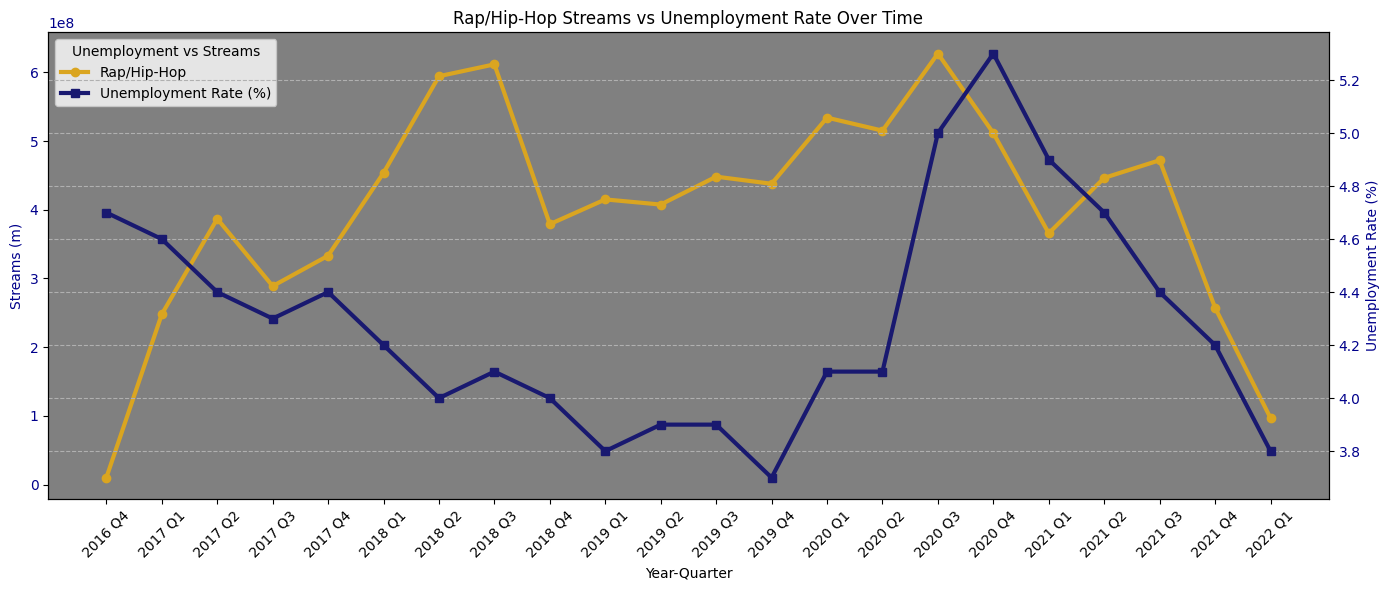

In [18]:
genre = 'Rap/Hip-Hop'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='goldenrod', linewidth='3', marker='o', label='Rap/Hip-Hop')
ax1.set_ylabel('Streams (m)', color='darkblue')
ax1.set_xlabel('Year-Quarter')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['unemployment_rate_(%)'], color='midnightblue', linewidth='3', marker='s', label='Unemployment Rate (%)')
ax2.set_ylabel('Unemployment Rate (%)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')


plt.title(f'{genre} Streams vs Unemployment Rate Over Time')
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='Unemployment vs Streams')


plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

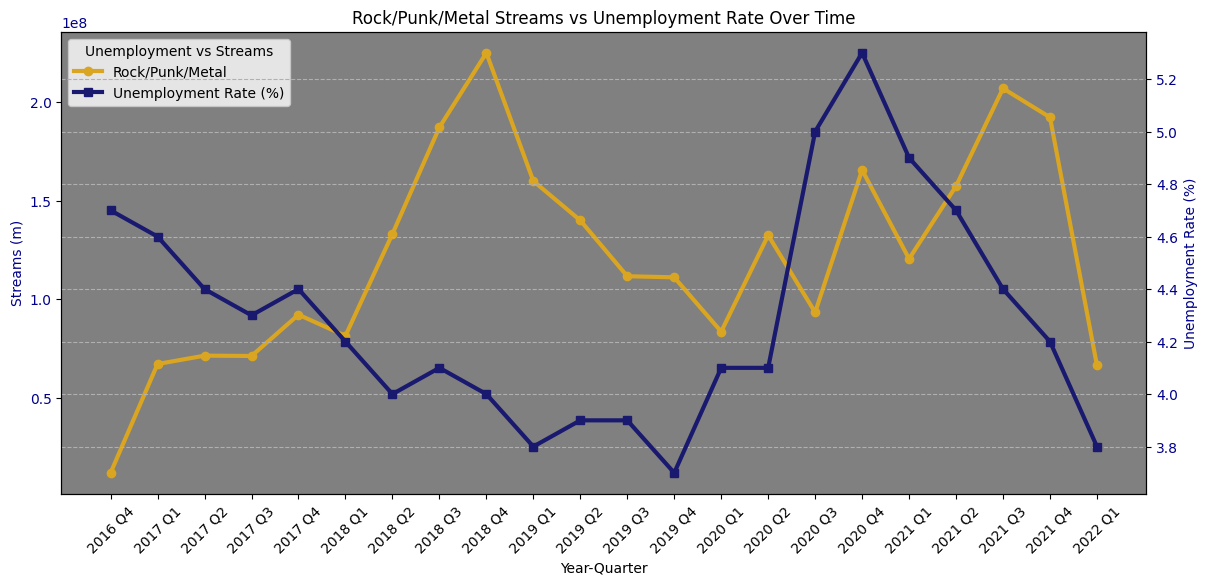

In [19]:
genre = 'Rock/Punk/Metal'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='goldenrod', linewidth='3', marker='o', label='Rock/Punk/Metal')
ax1.set_ylabel('Streams (m)', color='darkblue')
ax1.set_xlabel('Year-Quarter')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['unemployment_rate_(%)'], color='midnightblue', linewidth='3', marker='s', label='Unemployment Rate (%)')
ax2.set_ylabel('Unemployment Rate (%)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title(f'{genre} Streams vs Unemployment Rate Over Time')
# plt.xticks(rotation=45)
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='Unemployment vs Streams')


plt.grid(linestyle='--')
# plt.tight_layout()
plt.show()

### Rap/Hip-Hop and Rock/Punk/Metal Correlation with Unemployment

#### Rap/Hip-Hop and Rock/Punk/Metal show very weak coefficient correlation with unemloyment at 0.02 and -0.12 respectively. This could suggest that these genres' popularity is more culturally driven than economically driven. However in both genres their streams decline as unemployment spikes. The missing link might be who listens to these genres and why? Economic stress could manifest differently across demographics (anger vs. escapism).

#### If time allowed to take this project further I would like to look into:
- Spotify demographics and streaming behaviours. Who listens to these genres? And are Jazz listeners older/wealthier vs Rap/Hip-Hop’s younger audience?
- Regional/data granularity to see if unemployment spikes are localized? Streaming data might vary by region.
- Album releases popularising the genre and if this skewed the data?

### Correlation of music genres against GDP, Inflation and Unemployment

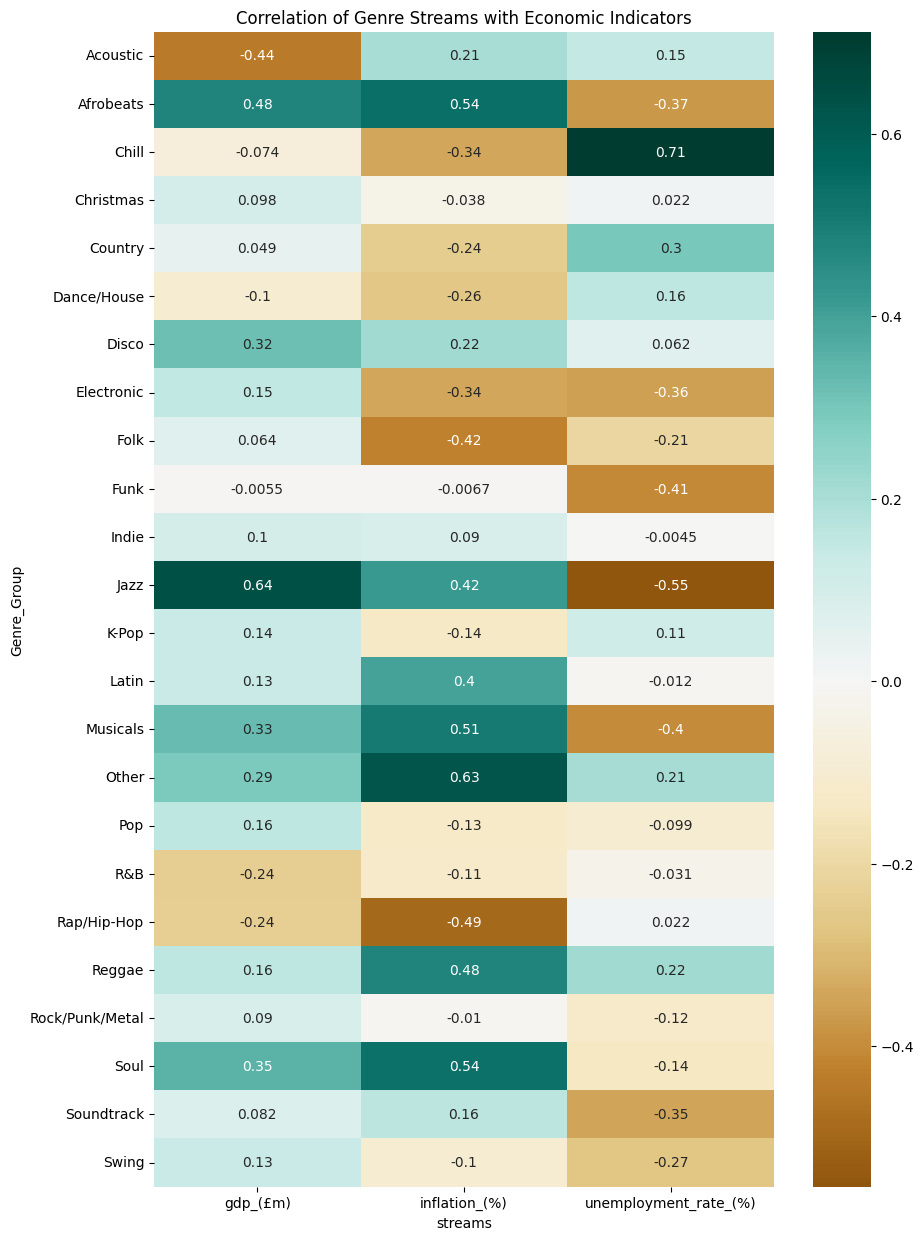

In [20]:
corr_by_genre = spotify_grouped_df.groupby('Genre_Group').apply(
    lambda g: g[['streams', 'gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']].corr().iloc[0, 1:]
)

plt.figure(figsize=(10, 15))
sns.heatmap(corr_by_genre, annot=True, cmap="BrBG", center=0)
plt.title('Correlation of Genre Streams with Economic Indicators')
# plt.tight_layout()
plt.show()

In [21]:
selected_genres = ['Jazz', 'Chill', 'Rap/Hip-Hop', 'Rock/Punk/Metal', 'Dance/House', 'Electronic']

genre_corrs = {}

for genre in selected_genres:
    un_genre_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre][
        ['streams', 'gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']
    ]
    corr = un_genre_df.corr().loc['streams'][
        ['gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']
    ]
    genre_corrs[genre] = corr

un_corr_summary_df = pd.DataFrame(genre_corrs).T
un_corr_summary_df.columns = ['GDP', 'Inflation', 'Unemployment']

un_corr_summary_df.round(2)

,GDP,Inflation,Unemployment
Jazz,0.64,0.42,-0.55
Chill,-0.07,-0.34,0.71
Rap/Hip-Hop,-0.24,-0.49,0.02
Rock/Punk/Metal,0.09,-0.01,-0.12
Dance/House,-0.10,-0.26,0.16
Electronic,0.15,-0.34,-0.36


## Correlation of Jazz, Chill, Rap/Hip-Hop, Rock/Punk/Metal, Electronic genres with Unemployment 


<img src="../data/images/Chill_Non_Chill_Unemployment_Coef.png" width=400px>


#### There is a possitive correlation with Chill genre streams and unemployment suggesting that people are looking to relax or for escapism during stressful times. I was interested to look into whether there would be a negative corelation with more aggressive genres like Rap/Hip-Hop or Rock/Punk/Metal and Electronic.  

I feel the findings reveal fascinating contrasts in how different music genres correlate with economic indicators. 

### Key Observations:
#### Chill Genre & Unemployment:
- Strong positive correlation (0.71): As unemployment rises, Chill streams increase significantly.
- People may seek calming music during stressful times especially around high unemployment during covid which was an extremely unprecedented time.
- More leisure time among unemployed listeners could lead to increased streaming.

#### Jazz Genre & Unemployment:
- Negative correlation with unemployment (-0.55): Jazz streams drop as unemployment rises.
- Positive correlation with GDP (0.64): Thrives in stronger economies.
- The potential outlier here is Jazz is often associated with affluent, urban settings (live venues, cultural engagement) where venues like Jazz clubs etc would be closed during covid I'd expect to see an increase in streams while people are listening to favourite music from home but the data shows the opposite. If there was time I would like to look into this further by extracting further data to increase sample size and carry out a thorough analysis on Jazz streams. 

#### Rap/Hip-Hop & Rock/Punk/Metal & Unemployment:
- Weak/no correlation with unemployment (0.02 and -0.12, respectively).
- Negative correlation with inflation (-0.49 and -0.01, respectively).
- These genres are less tied to economic conditions and more to cultural/age trends.
- Rap and rock often reflect societal angst, but their consumption may be stable across economic cycles.

#### Electronic & Unemployment:
- Moderate negative correlation with Unemployment (-0.36).
- Electronic music might be more popular in stable or prosperous times, perhaps due to its association with social settings like clubs, festivals, and parties — which decrease during economic stress.
- Higher unemployment may reduce discretionary spending on activities that include or drive streaming of Electronic music.
- People may turn to more calming or emotionally resonant genres like Chill during stress or hardship, rather than high-energy genres like Electronic.
- This behaviour aligns with the idea that music consumption reflects emotional or social needs, and Electronic music might not be the go-to during harder times.

## Rolling Correlation Chill Streams and Unemployment

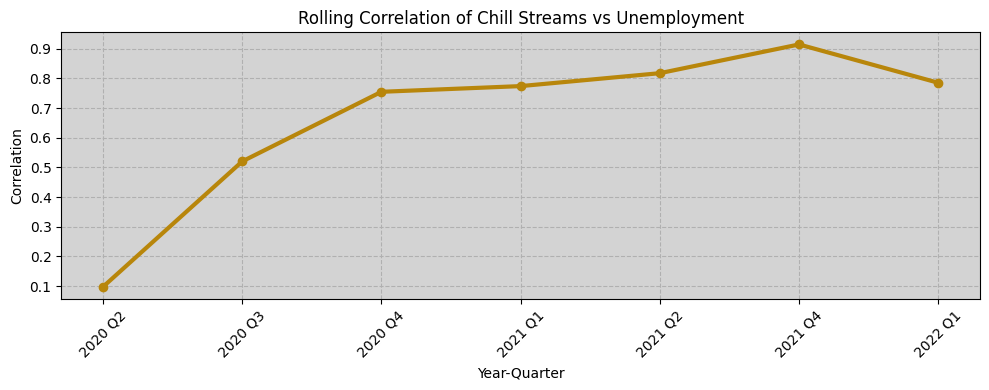

In [24]:
chill_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Chill'].sort_values('year_quarter')
chill_df = chill_df.sort_values('year_quarter')
rolling_corr = chill_df['streams'].rolling(window=4).corr(chill_df['unemployment_rate_(%)'])

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_facecolor('lightgrey')  

ax.plot(chill_df['year_quarter'], rolling_corr, marker='o', linewidth=3, color='darkgoldenrod')
ax.set_title('Rolling Correlation of Chill Streams vs Unemployment')
ax.set_xlabel('Year-Quarter')
ax.set_ylabel('Correlation')
ax.set_xticklabels(chill_df['year_quarter'], rotation=45)
ax.grid(linestyle='--')

plt.tight_layout()
plt.show()



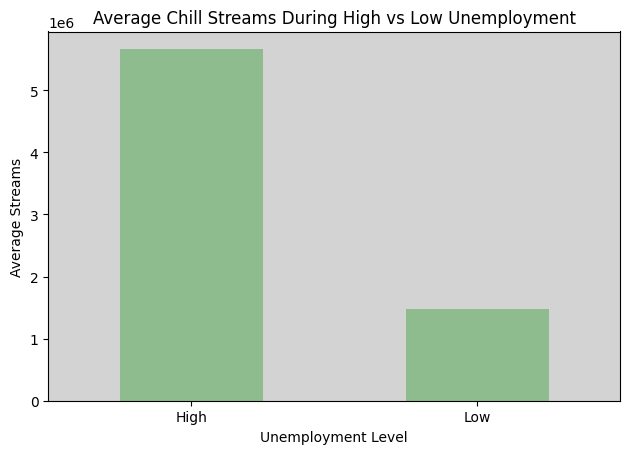

In [25]:
threshold = spotify_grouped_df['unemployment_rate_(%)'].median()
chill_df['unemployment_level'] = ['High' if x >= threshold else 'Low' for x in chill_df['unemployment_rate_(%)']]

avg_streams = chill_df.groupby('unemployment_level')['streams'].mean()

fig, ax = plt.subplots()
ax.set_facecolor('lightgrey') 

avg_streams.plot(kind='bar', color='darkseagreen', ax=ax)

ax.set_title('Average Chill Streams During High vs Low Unemployment')
ax.set_ylabel('Average Streams')
ax.set_xlabel('Unemployment Level')
ax.set_xticklabels(avg_streams.index, rotation=0)

plt.tight_layout()
plt.show()



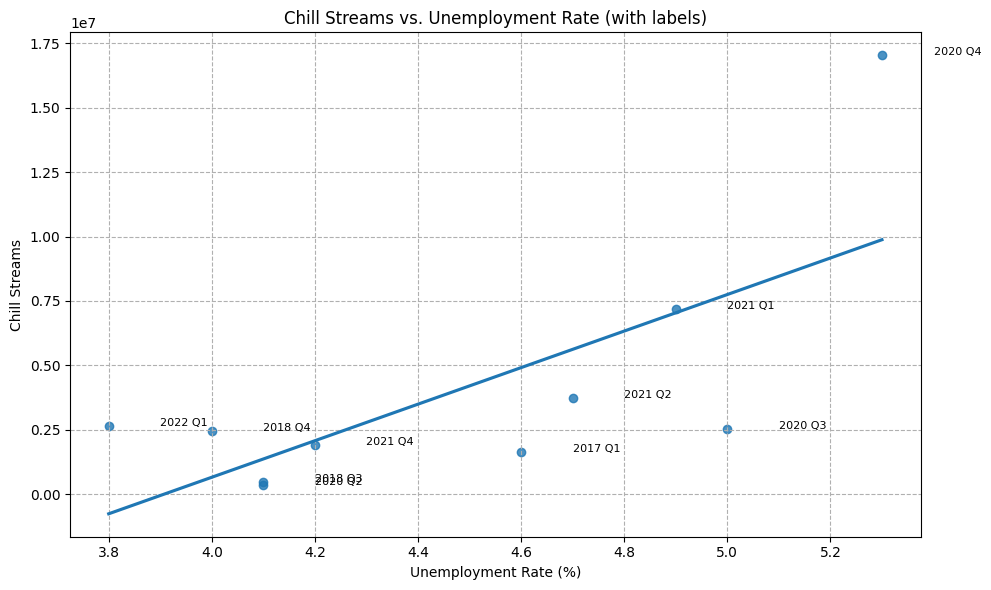

In [26]:
plt.figure(figsize=(10, 6))
sns.regplot(data=chill_df, x='unemployment_rate_(%)', y='streams', ci=None)

for i, row in chill_df.iterrows():
    plt.text(row['unemployment_rate_(%)'] + 0.1, row['streams'], row['year_quarter'], fontsize=8)

plt.title("Chill Streams vs. Unemployment Rate (with labels)")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Chill Streams")
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()


### Outliers from z-score are show as Chill streams increase rapidly during unemployment which is against the norm of the genre stream trends

In [27]:
chill_df['stream_z'] = zscore(chill_df['streams'])
outliers = chill_df[abs(chill_df['stream_z']) > 2] 
outliers.head()


,year_quarter,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%),unemployment_level,stream_z
294,2020 Q4,Chill,17042520.0,570338.0,0.8,335721.0,5.3,High,2.766276


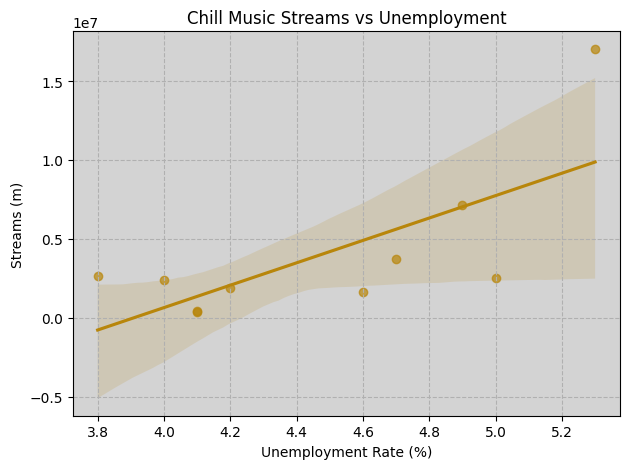

In [28]:
sns.regplot(
    data=chill_df, 
    x='unemployment_rate_(%)', 
    y='streams', 
    scatter_kws={'alpha':0.7},
    color='darkgoldenrod'
)

ax = plt.gca()
ax.set_facecolor("lightgrey")
plt.title('Chill Music Streams vs Unemployment')
plt.tight_layout()
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Streams (m)')
plt.grid(linestyle='--')
plt.show()


In [44]:
chill_df.head()

,year_quarter,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%),stream_z
17,2017 Q1,Chill,1614321.0,594423.0,2.2,372376.0,4.6,-0.502861
129,2018 Q3,Chill,465980.0,609653.0,2.3,380204.0,4.1,-0.746188
149,2018 Q4,Chill,2429989.0,610481.0,2.1,384035.0,4.0,-0.330027
256,2020 Q2,Chill,343885.0,481769.0,0.8,286546.0,4.1,-0.772059
276,2020 Q3,Chill,2527316.0,562648.0,0.8,342361.0,5.0,-0.309404


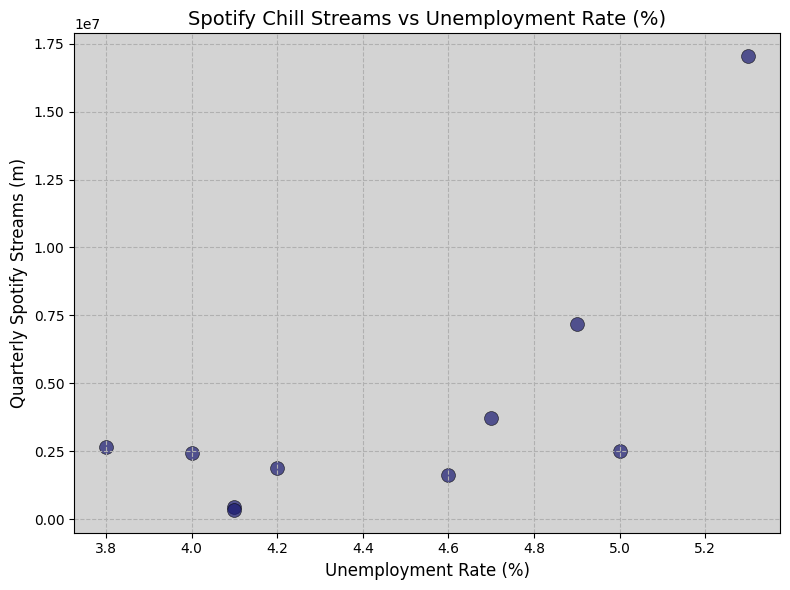

In [29]:
chill_data = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Chill']

X = chill_data['unemployment_rate_(%)'].values  
y = chill_data['streams'].values  

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X, y, color='midnightblue', alpha=0.7, edgecolor='black', linewidth=0.5, s=100)
ax.set_facecolor('lightgrey') 
    
ax.set_xlabel('Unemployment Rate (%)', fontsize=12)
ax.set_ylabel('Quarterly Spotify Streams (m)', fontsize=12)
ax.set_title('Spotify Chill Streams vs Unemployment Rate (%)', fontsize=14)
    
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()

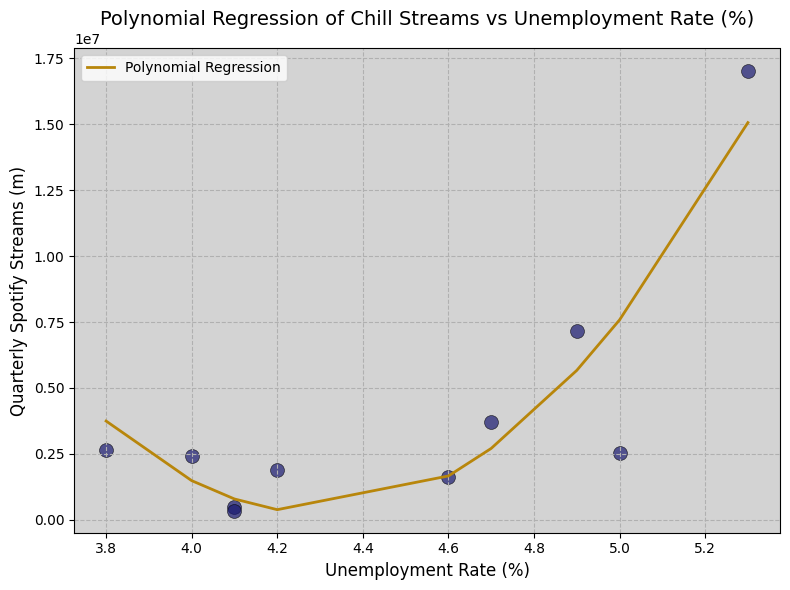

In [30]:
chill_data = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Chill']

X = chill_data['unemployment_rate_(%)'].values.reshape(-1, 1)  
y = chill_data['streams'].values  

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

y_pred = poly_reg_model.predict(X_poly)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X, y, color='midnightblue', alpha=0.7, edgecolor='black', linewidth=0.5, s=100)
ax.set_facecolor('lightgrey') 

X_sorted = np.sort(X, axis=0)

X_sorted_poly = poly.transform(X_sorted)

y_sorted_pred = poly_reg_model.predict(X_sorted_poly)

plt.plot(X_sorted, y_sorted_pred, color='darkgoldenrod', label="Polynomial Regression", linewidth=2)

ax.set_xlabel('Unemployment Rate (%)', fontsize=12)
ax.set_ylabel('Quarterly Spotify Streams (m)', fontsize=12)
ax.set_title('Polynomial Regression of Chill Streams vs Unemployment Rate (%)', fontsize=14)


plt.legend()
plt.grid(linestyle='--')

plt.tight_layout()
plt.show()


### Chill Genre Polynomial Regression and Unemployment 

#### U-Shaped Pattern:
- The trend dips slightly around 4.1–4.3% unemployment, then rises sharply beyond 4.5%.
- This suggests that when unemployment is relatively low to moderate, Chill streams don't increase much or may even dip slightly.
- However, as unemployment rises above 4.5%, Chill streaming increases steeply.

#### Emotional Response Hypothesis:
- The sharp rise at higher unemployment levels suggests people turn to Chill music more as economic stress intensifies.
- This could reflect listeners seeking comfort, relaxation, or escapism during difficult times.

#### Polynomial Fit vs Linear:
- The linear model above underestimates this relationship, especially at higher unemployment.
- The polynomial regression captures the inflection point and acceleration in Chill streaming.

## Summary of Findings, Next Steps and Lessons Learnt:
- Chill music becomes increasingly preferred as unemployment rises significantly, implying it's a genre that resonates during stressful or uncertain periods potentially functioning as a musical coping mechanism.
- Further analysis on demographics, Spotify users habits and regional shifts could should more insight into our findings.
- To approach this project differently ensuring there is sufficient data is crital in order to ensure our hypothesis is fully supported.